## Microsoft Malware Prediction

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

### Import Data

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [2]:
%%time

# Change working directory
os.chdir('C:/Users/vfarfan/DS/Ms')
# Load the data
df = pd.read_csv("data/train.csv"#, dtype={
#     'MachineIdentifier':'category', 'ProductName':'category', 'EngineVersion':'category', 'AppVersion':'category',
#        'AvSigVersion':'category', 'IsBeta':'category', 'RtpStateBitfield':'float', 'IsSxsPassiveMode':'category',
#        'DefaultBrowsersIdentifier':'category', 'AVProductStatesIdentifier':'category',
#        'AVProductsInstalled':'float', 'AVProductsEnabled':'float', 'HasTpm':'category',
#        'CountryIdentifier':'category', 'CityIdentifier':'category', 'OrganizationIdentifier':'category',
#        'GeoNameIdentifier':'category', 'LocaleEnglishNameIdentifier':'category', 'Platform':'category',
#        'Processor':'category', 'OsVer':'category', 'OsBuild':'int64', 'OsSuite':'int64', 'OsPlatformSubRelease':'category',
#        'OsBuildLab':'object', 'SkuEdition':'category', 'IsProtected':'float', 'AutoSampleOptIn':'int64', 'PuaMode':'category',
#        'SMode':'float', 'IeVerIdentifier':'float', 'SmartScreen':'category', 'Firewall':'float', 'UacLuaenable':'float',
#        'Census_MDC2FormFactor':'category', 'Census_DeviceFamily':'category',
#        'Census_OEMNameIdentifier':'category', 'Census_OEMModelIdentifier':'category',
#        'Census_ProcessorCoreCount':'float', 'Census_ProcessorManufacturerIdentifier':'category',
#        'Census_ProcessorModelIdentifier':'category', 'Census_ProcessorClass':'category',
#        'Census_PrimaryDiskTotalCapacity':'float', 'Census_PrimaryDiskTypeName':'category',
#        'Census_SystemVolumeTotalCapacity':'float', 'Census_HasOpticalDiskDrive':'int64',
#        'Census_TotalPhysicalRAM':'float', 'Census_ChassisTypeName':'category',
#        'Census_InternalPrimaryDiagonalDisplaySizeInInches':'float',
#        'Census_InternalPrimaryDisplayResolutionHorizontal':'float',
#        'Census_InternalPrimaryDisplayResolutionVertical':'float',
#        'Census_PowerPlatformRoleName':'category', 'Census_InternalBatteryType':'category',
#        'Census_InternalBatteryNmberOfCharges':'float', 'Census_OSVersion':'category',
#        'Census_OSArchitecture':'category', 'Census_OSBranch':'category', 'Census_OSBuildNumber':'int64',
#        'Census_OSBuildRevision':'int64', 'Census_OSEdition':'category', 'Census_OSSkuName':'category',
#        'Census_OSInstallTypeName':'category', 'Census_OSInstallLanguageIdentifier':'category',
#        'Census_OSUILocaleIdentifier':'category', 'Census_OSWUAutoUpdateOptionsName':'category',
#        'Census_IsPortableOperatingSystem':'int64', 'Census_GenuineStateName':'category',
#        'Census_ActivationChannel':'category', 'Census_IsFlightingInternal':'float',
#        'Census_IsFlightsDisabled':'float', 'Census_FlightRing':'category',
#        'Census_ThresholdOptIn':'float', 'Census_FirmwareManufacturerIdentifier':'category',
#        'Census_FirmwareVersionIdentifier':'category', 'Census_IsSecureBootEnabled':'int64',
#        'Census_IsWIMBootEnabled':'float', 'Census_IsVirtualDevice':'float',
#        'Census_IsTouchEnabled':'int64', 'Census_IsPenCapable':'int64',
#        'Census_IsAlwaysOnAlwaysConnectedCapable':'float', 'Wdft_IsGamer':'float',
#        'Wdft_RegionIdentifier':'category', 'HasDetections':'int64'
# }
    , nrows=1000000, low_memory=False
)

Wall time: 20.5 s


In [3]:
df['ProductName'] = pd.Categorical(df['ProductName'])

In [4]:
df = df.set_index('MachineIdentifier')
print('Dimensiones: ',df.shape)
df.head()

Dimensiones:  (1000000, 82)


,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,1.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


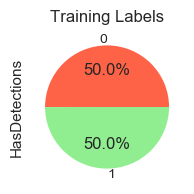

In [5]:
# df['OrganizationIdentifier'].value_counts()
colors = ['tomato','lightgreen']
df['HasDetections'].value_counts().plot.pie(figsize=(2,2), autopct='%1.1f%%', colors=colors)
plt.title('Training Labels')
plt.show()

#### Eliminar columnas con valores constantes
Elimino columnas con valores constantes o con sólo dos valores pero uno de ellos con muy poca frecuencia

In [6]:
df = df.drop('IsBeta', axis=1)
df = df.drop('AutoSampleOptIn', axis=1)
df = df.drop('PuaMode', axis=1)
df = df.drop('Census_IsFlightingInternal', axis=1)
df = df.drop('Census_IsFlightsDisabled', axis=1)
df = df.drop('Census_IsWIMBootEnabled', axis=1)

## Pre Processing

In [7]:
df['AppVersion_split'] = df['AppVersion'].str.split('.').str.get(1).astype(int)
df['AvSigVersion_split'] = df['AvSigVersion'].str.split('.').str.get(1)

## Feature Selection

In [8]:
training_features = ['ProductName', 'AppVersion_split', 'RtpStateBitfield', 'IsSxsPassiveMode', 'Firewall']

In [9]:
train = df[training_features]
train.head()

,ProductName,AppVersion_split,RtpStateBitfield,IsSxsPassiveMode,Firewall
MachineIdentifier,,,,,
0000028988387b115f69f31a3bf04f09,win8defender,18,7.0,0,1.0
000007535c3f730efa9ea0b7ef1bd645,win8defender,13,7.0,0,1.0
000007905a28d863f6d0d597892cd692,win8defender,18,7.0,0,1.0
00000b11598a75ea8ba1beea8459149f,win8defender,18,7.0,0,1.0
000014a5f00daa18e76b81417eeb99fc,win8defender,18,7.0,0,1.0


### Train/Validation Sets

In [55]:
from sklearn.model_selection import train_test_split

X = train
y = df.loc[:,'HasDetections']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_val.shape)
X_train.head()

(750000, 5)
(250000, 5)


,ProductName,AppVersion_split,RtpStateBitfield,IsSxsPassiveMode,Firewall
MachineIdentifier,,,,,
100e29768ba609b464dd3c1b3de567a9,win8defender,12,7.0,0,1.0
049288cab6eaed479f2277e672910f9d,win8defender,16,7.0,0,1.0
19d6cd70af9bbf7971af77caebcc256e,win8defender,14,7.0,0,1.0
05979ebc7692d3e9f3684ab9bebcf341,win8defender,18,7.0,0,1.0
19ae14fb212bb08e02949949aab037fe,win8defender,13,7.0,0,1.0


### Mean Encoding

In [56]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

enc_features = ['ProductName']

In [58]:
%%time

# Expanding mean encoding
# train_new = last_tx
# features={'event'}
X_train_mean_enc = X_train
X_train_mean_enc['HasDetections'] = y_train

for col in enc_features:
    cumsum = X_train_mean_enc.groupby(col)['HasDetections'].cumsum() - X_train_mean_enc['HasDetections']
    cumcnt = X_train_mean_enc.groupby(col).cumcount()
    X_train_mean_enc[col + '_mean_exp'] = cumsum/cumcnt
    X_train_mean_enc[col + '_mean_exp'] = X_train_mean_enc[col + '_mean_exp'].replace(np.inf, np.nan)
    X_train_mean_enc[col + '_mean_exp'] = X_train_mean_enc[col + '_mean_exp'].fillna(0)
    
    
    # Print correlation
#     encoded_feature = X_train_mean_enc[col + '_mean_exp'].values
#     print(encoded_feature)
#     print(col, np.corrcoef(X_train_mean_enc['label'].values, encoded_feature)[0][1])

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Wall time: 461 ms


C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [59]:
X_train_mean_enc.shape

(750000, 7)

#### Apply mean encoding to validation set

In [60]:
X_val_mean_enc = X_val
for feat in enc_features:
    means = X_val[feat].map(X_train_mean_enc.groupby(feat)[feat + '_mean_exp'].mean())
    X_val_mean_enc[feat + '_mean_exp'] = means
    X_val_mean_enc[feat + '_mean_exp'].fillna(prior, inplace=True)

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [63]:
X_val_mean_enc.head()

,ProductName,AppVersion_split,RtpStateBitfield,IsSxsPassiveMode,Firewall,ProductName_mean_exp
MachineIdentifier,,,,,,
0484b2093a19a1b2660ab55c9836f0d4,win8defender,18,7.0,0,1.0,0.500418
0ac6d4be17bcd9dc31c066b97661f822,win8defender,18,7.0,0,1.0,0.500418
13cab77fb75ae9cacd044d951e585e93,win8defender,18,7.0,0,1.0,0.500418
07a0b130998a4361b0e805f8a117852c,win8defender,11,7.0,0,1.0,0.500418
1b7307d18a1068f7234743a2dd52b8b3,win8defender,10,7.0,0,1.0,0.500418


In [64]:
X_train_mean_enc = X_train_mean_enc.drop('HasDetections', axis=1)
X_train = X_train_mean_enc.drop('ProductName', axis=1).fillna(0)
X_val = X_val_mean_enc.drop('ProductName', axis=1).fillna(0)

### Funciones para evaluación de modelos

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def predict_eval(model, X_test, y):    
    pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:,1]
    
    # Evaluamos el modelo
    roc_auc = roc_auc_score(y, pred)
    logit_roc_auc = roc_auc_score(y, pred_prob)
    
    print('ROC_AUC: ', roc_auc)
    print('LOGIT_ROC_AUC: ', logit_roc_auc)

    # Making the Confusion Matrix
    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y, pred)
    sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")

    # Plot the ROC AUC
    fpr, tpr, thresholds = roc_curve(y, pred_prob, pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label='AUC (area = %0.5f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.tight_layout()
    plt.show()
   
    return logit_roc_auc

from sklearn.model_selection import cross_val_score

def train_model(model, X_train, y_train, feat=False):
    #Fit the algorithm on the data
    model.fit(X_train, y_train)
        
    #Predict training set
    train_pred = model.predict(X_train)
    train_predp = model.predict_proba(X_train)[:,1]
    
    # CV
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score)
                                                                          ,np.min(cv_score),np.max(cv_score)))
    
    if feat:
        # Feature importance
        feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(10,2))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')  

## 0. Sample submission

In [ ]:
y_pred = np.zeros(len(y_val))
y_predp = y_pred + 0.5

# Evaluamos el modelo
roc_auc = roc_auc_score(y_val, y_pred)
logit_roc_auc = roc_auc_score(y_val, y_predp)

print('ROC_AUC: ', roc_auc)
print('LOGIT_ROC_AUC: ', logit_roc_auc)

# Making the Confusion Matrix
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")

fpr, tpr, thresholds = roc_curve(y_val, y_predp, pos_label=1)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='AUC (area = %0.5f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.tight_layout()
plt.show()

## 1. Logistic Regression

In [66]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.transform(X_val)

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """


CV Score : Mean - 0.5349317 | Std - 0.001277043 | Min - 0.5329364 | Max - 0.5363062
ROC_AUC:  0.529531204823
LOGIT_ROC_AUC:  0.535327183892


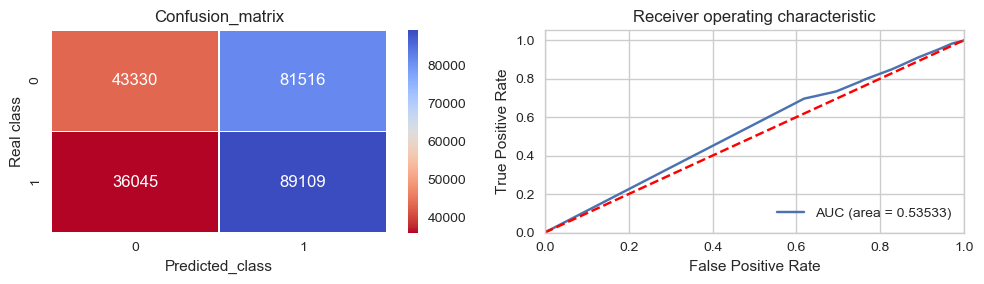

Wall time: 7.65 s


In [67]:
%%time

from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(solver='lbfgs')
train_model(lr_classifier, X_train_sc, y_train)

# Predict
predict_eval(lr_classifier, X_val_sc, y_val)

## 2. XGBoost

CV Score : Mean - 0.5444338 | Std - 0.002846206 | Min - 0.54058 | Max - 0.5478798
ROC_AUC:  0.539726077897
LOGIT_ROC_AUC:  0.548512432897


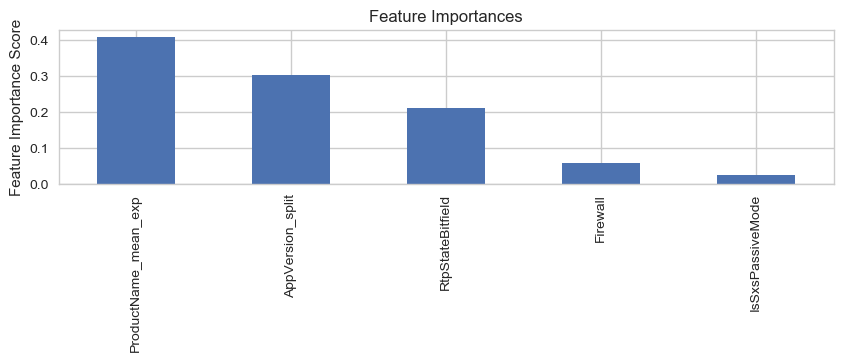

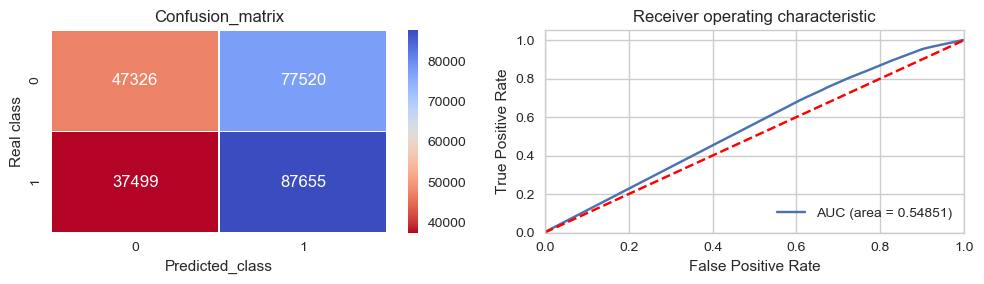

Wall time: 2min 6s


In [68]:
%%time

from xgboost import XGBClassifier

XGB_classifier = XGBClassifier()
train_model(XGB_classifier, X_train, y_train, feat=True)

# Predict
predict_eval(XGB_classifier, X_val, y_val)

# Prediction on Kaggle Test Set

In [70]:
%%time

# Load the data
dftest = pd.read_csv("data/test.csv")

<string>:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 2min 53s


In [71]:
dftest = dftest.set_index('MachineIdentifier')
dftest.shape

(7853253, 81)

### Pre processing

In [72]:
dftest['AppVersion_split'] = dftest['AppVersion'].str.split('.').str.get(1).astype(int)
dftest['AvSigVersion_split'] = dftest['AvSigVersion'].str.split('.').str.get(1)
test = dftest[training_features]
test.head()

,ProductName,AppVersion_split,RtpStateBitfield,IsSxsPassiveMode,Firewall
MachineIdentifier,,,,,
0000010489e3af074adeac69c53e555e,win8defender,18,7.0,0,1.0
00000176ac758d54827acd545b6315a5,win8defender,18,7.0,0,1.0
0000019dcefc128c2d4387c1273dae1d,win8defender,18,7.0,0,1.0
0000055553dc51b1295785415f1a224d,win8defender,18,7.0,0,1.0
00000574cefffeca83ec8adf9285b2bf,win8defender,18,7.0,0,1.0


### Feature encoding

In [73]:
test_enc = test
for feat in enc_features:
    means = test[feat].map(X_train_mean_enc.groupby(feat)[feat + '_mean_exp'].mean())
    test_enc[feat + '_mean_exp'] = means
    test_enc[feat + '_mean_exp'].fillna(prior, inplace=True)

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [75]:
test_enc.head()

,ProductName,AppVersion_split,RtpStateBitfield,IsSxsPassiveMode,Firewall,ProductName_mean_exp
MachineIdentifier,,,,,,
0000010489e3af074adeac69c53e555e,win8defender,18,7.0,0,1.0,0.500418
00000176ac758d54827acd545b6315a5,win8defender,18,7.0,0,1.0,0.500418
0000019dcefc128c2d4387c1273dae1d,win8defender,18,7.0,0,1.0,0.500418
0000055553dc51b1295785415f1a224d,win8defender,18,7.0,0,1.0,0.500418
00000574cefffeca83ec8adf9285b2bf,win8defender,18,7.0,0,1.0,0.500418


In [76]:
test_enc = test_enc.drop('ProductName', axis=1).fillna(0)


## XGBoost

(7853253, 1)


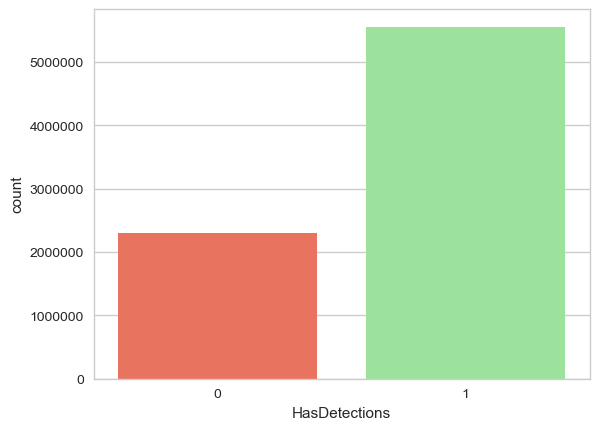

1    5555100
0    2298153
Name: HasDetections, dtype: int64
Wall time: 52.3 s


In [77]:
%%time

# Predicción de los labels 0 o 1
predictions = XGB_classifier.predict(test_enc)
dfsub = pd.DataFrame(predictions, columns=['HasDetections'], index=test_enc.index)
print(dfsub.shape)

sns.countplot('HasDetections',data=dfsub, palette=colors)
plt.show()

print(dfsub['HasDetections'].value_counts())

# Predicción de la probabilidad de conversión
predictions = XGB_classifier.predict_proba(test_enc)
dfsub = pd.DataFrame(predictions[:,1], columns=['HasDetections'], index=test_enc.index)

predictions[:,1]

In [78]:
dfsub.head()
dfsub.shape

(7853253, 1)

In [79]:
dfsub.to_csv('20181216_XGB_exp.csv', sep=',', header=True)